# Flightpath characterization
In this notebook we look at the characterization of the flight path through the Discrete Algebraic Equations, and show how to optimize over it.

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../source/Noise/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.sparse as sparse

from InverseProblem import InverseProblem
from NoiseBayes import NoiseBayes as Noise

from FOM_stationary import FOM_stationary as FOM
from OEDUtility import OEDUtility
from Drone import Drone as Drone

from DetectorPointwise import DetectorPointwise
from DetectorUniform import DetectorUniform
from DetectorGaussian import DetectorGaussian
from DetectorTruncGaussian import DetectorTruncGaussian

# specify which navigation class we are using
from NavigationDAE import NavigationDAE as Navigation

from Optimization.Optimization import Optimization as Optimizer
from Constraints import Constraints
from Flight import Flight

import time
tStart_notebook = time.time()

## User settings

These are essentially the only settings the user needs to provide to run this notebook. We have:
- `centers`: the positions around which the parameter basis functions (gaussians) are centered. The goal of the inverse problem is to determine the scaling for each basiss function from measurements. `centers` is a list which can contain an arbitrary number of centers, each center being a list of x-value and y-value. Make sure to only choose centers that are within the modelled domain.
- `n_steps`: number of time steps for the flight path discretization
- `t_final`: final time for the flight (flight starts at t=0)
- `meshDim`: the meshing parameter for the discretization of the forward model. This is _not_ the final dimension of the forward model, just _approximately_ how many nodes are distributed in x- and y-direction. The mesh itself is unstructured. A convergence analysis for how much the utility function and its gradient changes w.r.t. the mesh discretization is provided in notebook 3.
- `polyDim`: Polynomial degree for the finite element basis functions. For the gradients of the utility functions it is beneficial to choose `polyDim` $\ge 2$, otherwise the gradients are piecewise constant. 
- `para_true`: parameter at which we take measurements for illustration purposes below. Does _not_ change the optimization, just the visualization below. `para_true` needs to have as many entries as there are centers in `centers`.

In [2]:
centers = [[0.6, 0.4], [0.4, 0.6]]

n_steps = 500
t_final = 1

meshDim = 20  # discretization parameter (1D) for FOM
polyDim = 3

para_true = np.ones((len(centers),))

utility_mode = "A" # choose between "A" and "D"

## Setup

We first initialize the **forward model** (parameter to state). In the imports above we have loaded in `FOM_stationary` under the name `FOM`. This is our stationary diffusion-advection-reaction model.

In [3]:
tStart = time.time()

# initialize full-order model
fom = FOM(meshDim = meshDim, centers=centers, polyDim=polyDim)
n_para = fom.n_para

print("Runtime of this block: {} s".format(time.time()-tStart))

Runtime of this block: 0.3562190532684326 s


For nicer visualization below we compute one solution of the forward model at `para_true`. This also gives us an idea how long the preprocessing for the computing the utility functions is going to take (about `n_para` times as long, as we need to solve the PDE once for each parameter).

In [4]:
tStart = time.time()

# compute one solution for nicer visualization below
state = fom.solve(parameter=para_true)

print("Compute-time for one PDE forward solve: {} s".format(time.time()-tStart))

Compute-time for one PDE forward solve: 5.37288498878479 s


Here's what the solution looks like, in case you'd still like to go back and change the position of the pullutant sources.

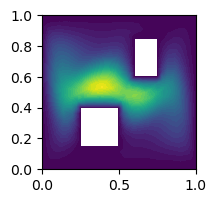

In [5]:
fig, ax = plt.subplots(1,1, figsize = (2,2))
fom.plot(state, ax=ax)

Next is the **prior** (Bayesian setting) or **parameter regularization** (deterministic setting). Either case works analogously and is done with the same code. In the code below we are using a Gaussian prior centered around 0, and with the identity matrix as covariance matrix, but the user can feel free to choose a different prior mean, covariance matrix, or scale the importance of the prior with the scaling parameter `var_prior`. The only constraints are that `prior_mean` is an array of length `n_para` (the number of uncertain parameters), `prior_covar` is symmetric positive definite of size `n_para` $\times$ `n_para`, and `var_prior` is strictly positive.

In [6]:
tStart = time.time()

# optional user settings:
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)

# set a prior
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

print("Runtime of this block: {} s".format(time.time()-tStart))

Runtime of this block: 0.00022125244140625 s


Next are the initialization of
- `navigation`: the part of the code that manages how controls are interpreted, and how they translate to positions in the domain, i.e., the control-to-parameter map. Above, we imported `NavigationDAE` as `Navigation`, which is our navigation class that uses the discrete algebraic equations to compute the positions.
- `detector`: the part of teh code that manages how measurements are taken. In the code block below we are using pointwise measurements to keep everything fast via testing, but other measurement types can be chosen by switching out `DetectorPointwise`. See notebooks 2 and 6 for an overview. Mind though - the convolution type measurements take a bit longer to compute.
- `drone`: an interface between the forward model `fom`, the navigation, and the detector so that we don't need to carry them around with us individually.

In [7]:
tStart = time.time()

# NavigationDAE was imported as Navigation
navigation = Navigation(grid_t = np.linspace(0, t_final, n_steps))

# point-wise measurements
detector = DetectorPointwise(fom)

# initialize drone
drone = Drone(detector=detector, navigation=navigation, fom=fom)

print("Runtime of this block: {} s".format(time.time()-tStart))

Runtime of this block: 0.00026488304138183594 s


The noise model is again an optional user setting. The deterministic and the Bayesian setting are very similar, except that we require the diffusion coefficient in the Bayesian setting to be positive in order to make the noise covariance operator trace class. It's somewhat confusing, I really haven't found a good explanation yet. For `c_scaling = 1e+3`, `c_diffusion = 1`, the signal-to-noise ratio is, on average, approximately 20. If `c_diffusion = 0`, we are in the setting currently described in the manuscript (deterministic setting).

While the structure of the inverse problem is analogue for the different scaling, they actually have very interesting effects on the optimal flight path: When including diffusion, the optimal flight path likes to touch boundaries where the measurements are only noise. This lets the inverse problem get an estimate how large the noise must be in the surrounding area. Somehow, with the diffusion, the inverse problem is also more sensitive to the drone flying outside of the domain due to the boundary conditions in the time domain (see notebook `test_derivative` in the subfolder `checks`).

In [8]:
tStart = time.time()

# deterministic setting
noise = Noise(grid_t = drone.grid_t)
noise.parameterize_noise_model(c_scaling = 1e+3, c_diffusion = 0)

# set noise model
inversion = InverseProblem(fom, drone, noise=noise)

print("Runtime of this block: {} s".format(time.time()-tStart))

Runtime of this block: 0.004975080490112305 s


Finally, we initialize the `OEDutility` class, which contains all the code about evaluating the A- or D-OED utility function for a given posterior distribution.

In [9]:
# initialize utility functions
utility = OEDUtility(default_mode=utility_mode)

## Path characterization

For the DAE flightpath characterization, a flightpath is uniquely defined by:
- the initial position `initial`, containing the x- and y- coordinate at time t=0, and the initial heading (in radians). Hence, `initial` is an array with 3 entries.
- the velocity `velocity` at each time step, discretized to an array with `n_steps` entries. Even though we have a stationary model, the velocity is still important because it gives a local weight to the measurements, especially in combination with the noise model (slower velocity means more time is taken to take measurements). However, if we want to treat the flightpath just as a parameterized curve, we can just keep the velocity constant. That's also easiest to interpret.
- the velocity `angular_velocity` with which the heading of the drone changes in time.

The three control parameters `initial`, `velocity`, and `angular_velocity` are collected in our control parameter `alpha`.

In [10]:
initial = np.array([0.7, 0.3, 2])
velocity = np.array([0.8]*n_steps)
angular_velocity = np.array([1]*n_steps)

alpha = np.hstack([initial, velocity, angular_velocity])

By solving the ODE
$$
\dot{x} = v ~cos(\theta), \qquad  \dot{y} = v ~ sin(\theta), \qquad \dot{\theta} = \omega
$$
with velocity $v$ and angular velocity $\omega$ for the $x$ and $y$ positions of the drone and its heading $\theta$, we obtain the flightpath $p(t) = (x(t), y(t))$.
In the `NavigationDAE` class, the ODE is currently solved using forward Euler time-stepping. To get the flightpath for the provided initial condition, velocity, and angular velocity, we just ask the drone to plan out the corresponding flfight:

(-0.05, 1.05)

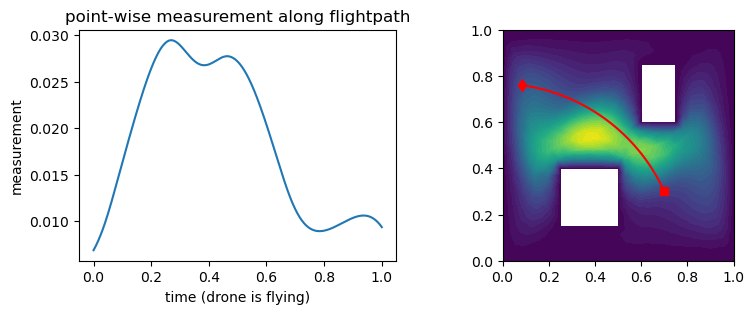

In [11]:
# compute flight
flight = drone.plan_flight(alpha=alpha, grid_t=drone.grid_t)  # Flight object
flightpath, grid_t, valid_positions = flight.get_positions()  # path and its time discretization

# measure data
data = drone.measure(flight=flight, state=state)

fig, axs = plt.subplots(1, 2, figsize = (9, 3))
fom.plot(state, ax=axs[0])
axs[1].plot(flightpath[:, 0], flightpath[:, 1], color="r")
axs[1].plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
axs[1].plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

axs[0].plot(grid_t, data)
axs[0].set_xlabel("time (drone is flying)")
axs[0].set_ylabel("measurement")
axs[0].set_title("point-wise measurement along flightpath")
axs[0].set_xlim(grid_t[0]-0.05, grid_t[-1]+0.05)

It is _very, very important_ that we are not just treating missing measurements as zero. Remember that we are using a correlated noise model. Substituting missing measurements with zero is not the same as taking them out. For this reason, each flight contains, in addition to its positions `flightpath` at any time in the time discretization `grid_t`, also the array `valid_positions` which contains for each time step whether the path is at a valid positions for taking measurements. If not, then the code for computing the posterior distribution will disregard those parts of the measurements. As this means less measurements are obtained, this usually means that the utility function is larger and the optimization thus avoids these areas (even when no obstacles are enforced).

To compute the posterior distribution for any flightpath, we call the inverse problem `inversion`. Note that since we have a linear parameter-to-state map, the posterior covariance matrix is independent from the measurements, and we can compute it without actually specifying measurement data:

In [12]:
# compute posterior
posterior_ref = inversion.compute_posterior(alpha=alpha)
util_ref = [utility.eval_utility(posterior_ref, mode="A"), utility.eval_utility(posterior_ref, mode="D")]

print("A-OED:", util_ref[0])
print("D-OED:", util_ref[1])
print("E-OED:", utility.eval_utility(posterior_ref, mode="E"))

print("\nPosterior covariance matrix:\n", posterior_ref.compute_covariance())

/Users/nicole/git/m2dtIceSheet/notebooks/../source/InverseProblem.py:240: UserWarning: InverseProblem.get_states: No saved states. Computing and saving with standard basis.
  warnings.warn(


A-OED: 1.734271286532421
D-OED: 0.7505496743361169
E-OED: 0.9042105604824076

Posterior covariance matrix:
 [[ 0.87467936 -0.03629934]
 [-0.03629934  0.85959193]]


If we would  indeedlike to solve the inverse problem for given measurement data, we can of course still do that:

In [13]:
print("prior mean:     ", prior_mean)
print("posterior mean: ", posterior_ref.compute_mean(data))
print("true parameter: ", para_true)

prior mean:      [0. 0.]
posterior mean:  [0.16161997 0.17670741]
true parameter:  [1. 1.]


In our code above, we have a relatively strong prior in comparison to our data. To see convergence towards the true parameter, increase `var_prior` (larger variance in the prior, i.e., prior is less strong), or decrease the scaling parameter `c_scaling` in the noise model (noise model is less dominant). In these cases our computations above converge towards the true parameter in the limit since we did not perturb the measurement data with any noise. In a real-world setting, this would of course not be the case but it's always good for testing and checking.

## Optimization

### Constraints
For the optimization, we want to set some constraints on the control parameters and make sure the flightpath positions do not end up outside the modelled domain. Since the control parameters are encoded in `navigation`, we use its functionality to check control constraints. This way, all the information is kept in one place and we do not end up with conflicting implementations.

First, we define the lower and upper limits for the controls. This is done through `navigation.set_control_bounds`. We have a lower bound and an upper bound each for the initial x position, initial y position, initial heading, velocity at all time steps, and angular velocity at all time steps. If we want to restrict the velocity or angular velocity non-uniformly over the time domain (e.g., sharp maneuvres only at the end of the flight), this needs to be adjusted manually for the moment.

The next code-block sets:
- fixed values for the initial position and the velocity so that none of them are varied throughout the optimization
- the initial heading may be in any direction,
- sets a lowest allowed angular velocity of -5, and maximum allowed angular velocity of +5 (this is what gets varied)
- sets upper and lower bounds for the positions so that they never leave the modelled domain.

The user can of course choose other lower and upper bounds. It's very fun to play around and try things out in my opinion.

In [14]:
# convert scalar upper and lower bounds into the right shape for the controls
navigation.set_control_bounds([0.7, 0.3, 0, 0.8, -5], [0.7, 0.3, 2*np.pi, 0.8, 5])

# extend with lower bounds for the positions
lower = np.hstack([np.zeros((2*n_steps,)), -np.infty * np.ones((n_steps,)), navigation.lower])

# extend with upper bounds for the positions
upper = np.hstack([np.ones((2*n_steps,)), np.infty * np.ones((n_steps,)), navigation.upper])

Of course we have additional constraints as well, primarily we want to avoid the two houses in the domain, but there might be other restrictions depending on the model. The class `Constraints` has all the code to handle constraints for us, to make the optimization class below a little less crowded and not flood the navigation class with all the extra information that is not necessarily part of the control-to-flightpath map.

To initialize `constraints`, we only need to tell it about the navigation system. Remember that `navigation` has all the code for how to convert controls into parameters. The `Constraints` class is able to work with all our flightpath characterizations encoded in any of the `Navigation` classes. This way we can easily switch out flightpath characterizations.

In [15]:
constraints = Constraints(navigation = navigation)

# tell the constraints class about the upper and lower bounds
constraints.set_bounds(lower, bool_lower = True)
constraints.set_bounds(upper, bool_lower = False)
# todo: this latter part could really be automated and become part of the initialization of constraints

We can add any of our obstacles by calling `constraints.add_obstacle`. It will take care of managing these constraints for us. Note that we have not hard-coded any of these, so the user can easily try out additonal constraints or leave some out to build their intuition. We have three types of obstacles: "circle", "square", and "diamond". Each is characterized by a center (x- and y-position) and extends into each direction. See documentation for details.

In [16]:
# houses: do not fly outside the modelled domain
constraints.add_obstacle("square", [(0.5 + 0.25) / 2, (0.4 + 0.15) / 2, (0.5 - 0.25) / 2, (0.4 - 0.15) / 2])
constraints.add_obstacle("square", [(0.75 + 0.6) / 2, (0.85 + 0.6) / 2, (0.75 - 0.6) / 2, (0.85 - 0.6) / 2])

# additional constraints for testing:
# constraints.add_obstacle("circle", [0.3, 0.5, 0.2, 0.1])

### Initial guess for flight
We need to provide an initial guess for the optimization. For the DAE flightpath characterization, this initial guess contains
- the x- and y-positions at each time step,
- the heading at each time step,
- the control paramters.

The first three are saved in the columns of `flight.flightpath`. The control parameters we've already stacked up in `alpha`. To get our initial guess, we thus only need to stack everything together in one long array.

**Note:** The variable `flightpath` above contains only the x- and y-positions, while `flight.flightpath` contains additionally the heading as third column. This is a very confusing naming choice and will be updated in the future.

In [17]:
x_y_theta = np.hstack([flight.flightpath[:, i] for i in range(flight.flightpath.shape[1])])
x0 = np.hstack([x_y_theta, alpha])

Before using this initial guess, we should check if it's within all our constraints. If not, all sorts of things can go wrong, primarily the position and the control parts get detached and we have large dual constraint violations. It's much better to start off from a valid path. To check, we run the following code steps:

In [18]:
tol = 1e-15

print("Sanity check (positional, upper):  ", (x0 <= constraints.upper_bounds + tol).all())
print("Sanity check (positional, lower):  ", (x0 >= constraints.lower_bounds - tol).all())

yolo = (constraints.evaluate_constraints(x_y_theta, alpha) <= constraints.constraints_upper + tol).all()
print("Sanity check (constraints, upper): ", yolo)

yolo = (constraints.evaluate_constraints(x_y_theta, alpha) >= constraints.constraints_lower - tol).all()
print("Sanity check (constraints, lower): ", yolo)

Sanity check (positional, upper):   True
Sanity check (positional, lower):   True
Sanity check (constraints, upper):  True
Sanity check (constraints, lower):  True


**Note:** Since everything is was computed with machine precision, we are admitting a tolerance here to check that the constraints are met.

### Optimization

For the optimization we use `ipopt`. As an interface, we have the `Optimization` class, it is a subclass of `cyipopt.Problem`. To initialize, we let it know
- which utility function `utility` we work with
- the all the details of the inverse problem (e.g., noise model) through the class `inversion`
- and of course all the constraints we've set up above: `constraints`

In [19]:
problem_obj = Optimizer(utility=utility, inverse_problem=inversion, constraints=constraints)

As a subclass of `cyipopt.Problem`, we can set a bunch of solver settings. Some convenient ones are:

In [20]:
problem_obj.add_option("hessian_approximation", "limited-memory")
problem_obj.add_option("tol", 1e-4)
#problem_obj.add_option("max_iter", 100)

In addition, we have a regularization strength parameter that let's us adjust how strongly we want to regularize the controls:

In [21]:
problem_obj.reg_strength = 1e-10

And not we solve the optimization problem. This may take some time depending on the control and number of time steps.

In [22]:
solution, info = problem_obj.solve(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     4495
Number of nonzeros in inequality constraint Jacobian.:     2000
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2001
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1501
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1500
Total number of inequality c

### Plotting the solution

Now that we've solved the optimization, we want to take a look at how well we did. The plot (right side) below has:
- **red:** our initial guess 
- **green:** the optimal flight path according to the _position_ part of `solution`
- **yellow, dashed:** the optimal flight path according to the _control_ part of `solution`

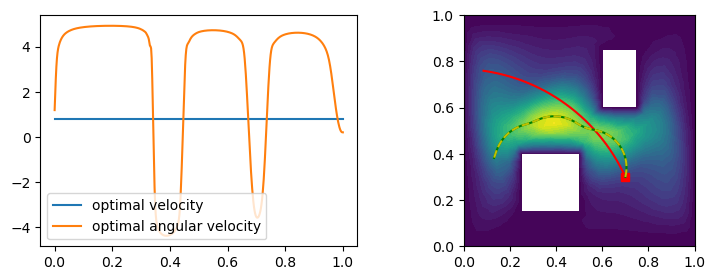

In [23]:
# split up the solution in flight path and controls
(flightpath_1d_opt, controls_opt) = problem_obj.var_splitter(solution)
flight_controlled = Flight(navigation=navigation, alpha = controls_opt)
flight_by_path = Flight(navigation=navigation, flightpath = flightpath_1d_opt)

# initialize figure
fig, axs = plt.subplots(1, 2, figsize = (9, 3))
fom.plot(state, ax=axs[0])

# plot the controls of the found solution
__, velocity_opt, ang_velocity_opt = navigation.split_controls(controls_opt)
axs[0].plot(grid_t, velocity_opt, label = "optimal velocity")
axs[0].plot(grid_t, ang_velocity_opt, label = "optimal angular velocity")
axs[0].legend()

# plot the initial guess, mark the start
axs[1].plot(flightpath[:, 0], flightpath[:, 1], color="r")
axs[1].plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")

# plot the found flight path
axs[1].plot(flight_by_path.flightpath[:, 0], flight_by_path.flightpath[:, 1], color="g")
axs[1].plot(flight_controlled.flightpath[:, 0], flight_controlled.flightpath[:, 1], color="y", linestyle = "--")

In the plot on the left side we additionally have the identified controls as a function of time. Note that the velocity was constrained to be 1 everywhere.

## The End.

In [24]:
runtime_notebook = time.time()-tStart_notebook
print("Runtime of this notebook: {} min".format(runtime_notebook / 60))

Runtime of this notebook: 0.34959686994552613 min
